# Play with piecewise registration
import stuff

In [66]:
import sys
sys.path.insert(0, '..')
import pwreg
import torch
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

## Load some data

In [2]:
X = pwreg.Dataset('../data/nissl_2.nii.gz', '../data/tau_2.nii.gz', '../data/nissl_chunk_mask_2.nii.gz', torch.float)

In [41]:
I_fix, I_mov, I_fmsk = X.I_fix.downsample(0.08), X.I_mov.downsample(0.08), X.M_fix.downsample(0.08)

In [42]:
I_fix.T.shape, I_fix.ras

(torch.Size([1, 1, 116, 82]),
 array([[-0.50238047,  0.        , -0.23119257],
        [ 0.        , -0.50017587, -0.2300809 ],
        [ 0.        ,  0.        ,  1.        ]]))

## Create a rigid registration problem

In [43]:
R=pwreg.RigidProblem(I_fix, I_mov, I_fmsk)

Check that the RAS mapping is correct - should line up with `c2d data/nissl.nii.gz -info -resample 172x186 -info-full -probe 60x80vox`

In [44]:
test = torch.nn.functional.affine_grid(torch.Tensor([[1.,0.,0.],[0.,1.,0.]]).unsqueeze(0),
                                       I_fix.T.shape, align_corners=False)

In [45]:
q2 = torch.nn.functional.grid_sample(I_fix.T, test, mode='bilinear', padding_mode='zeros', align_corners=False)

In [46]:
q2[:,:,80,60]

tensor([[0.2089]])

In [47]:
R.R_fix @ np.array([test[:,80,60,1].item(), test[:,80,60,0].item(), 1])

tensor([-42.9764, -28.4426,   1.0000], dtype=torch.float64)

## Play

In [48]:
theta = torch.tensor(np.zeros(8), requires_grad=True, dtype=torch.float)
dx = torch.tensor(np.zeros(8)+0.1, requires_grad=True, dtype=torch.float)
dy = torch.tensor(np.zeros(8)-0.2, requires_grad=True, dtype=torch.float)

In [49]:
A = R.compute_tform(theta, dx, dy)
q = R.apply_tform_to_moving(A)

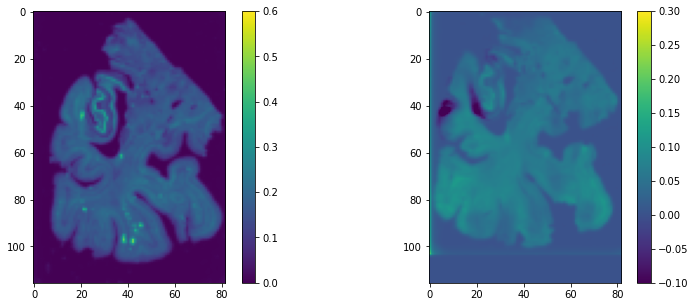

In [50]:
fig, (ax1, ax2) = plt.subplots(figsize=(13, 5), ncols=2);
fig.colorbar(ax1.imshow(R.I_fix.T.squeeze(), vmin=0.0, vmax=0.6), ax=ax1);
fig.colorbar(ax2.imshow(q[0,0,:,:].detach(), vmin=-0.1, vmax=0.3), ax=ax2);

In [51]:
I,J,M = R.I_fix.T, q, R.M_fix.T

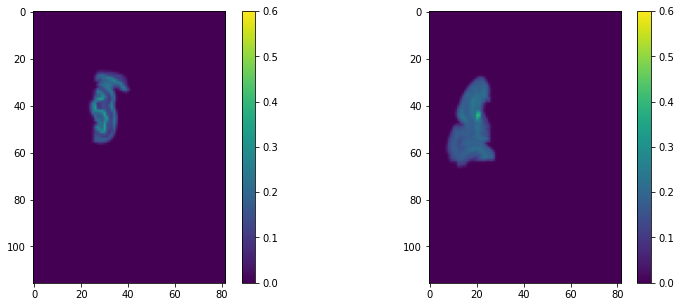

In [52]:
# Show the masked image piece
fig, (ax1, ax2) = plt.subplots(figsize=(13, 5), ncols=2);
fig.colorbar(ax1.imshow((I*M)[0,0,:,:], vmin=0.0, vmax=0.6), ax=ax1);
fig.colorbar(ax2.imshow((I*M)[1,0,:,:], vmin=0.0, vmax=0.6), ax=ax2);

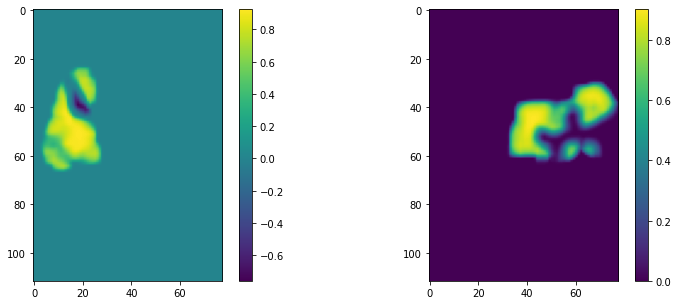

In [53]:
ncc_obj = pwreg.ChunkNCC(8, 2)
ncc_test = ncc_obj.ncc_maps(I,J,M)
fig, (ax1, ax2) = plt.subplots(figsize=(13, 5), ncols=2)
fig.colorbar(ax1.imshow(ncc_test[1,:,:].detach()), ax=ax1)
fig.colorbar(ax2.imshow(ncc_test[3,:,:].detach()), ax=ax2)

In [54]:
ncc_obj(I,J,M)

tensor([0.5875, 0.7312, 0.8428, 0.6470, 1.1073, 0.7595, 0.5965, 0.8489],
       grad_fn=<DivBackward0>)

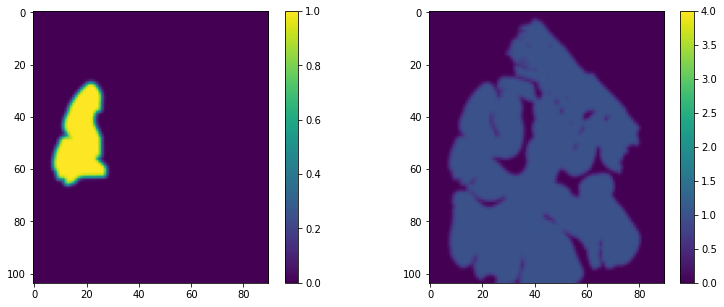

In [55]:
A_inv = torch.inverse(A)
M_inv = R.ovl.overlap_image(A_inv)
fig, (ax1, ax2) = plt.subplots(figsize=(13, 5), ncols=2)
fig.colorbar(ax1.imshow(M_inv[1, 0, :, :].detach()), ax=ax1)
fig.colorbar(ax2.imshow(torch.sum(M_inv, axis=0).squeeze().detach(), vmin=0, vmax=4), ax=ax2)

In [56]:
# f_opt = lambda : torch.sum(1-R(theta, dx, dy))
def f_opt():
    ncc, ovl = R(theta, dx, dy)
    obj = torch.sum(1-ncc) + 10. * ovl
    return ncc, ovl, obj

optimizer = torch.optim.LBFGS([theta, dx, dy],
                              history_size=10,
                              max_iter=4,
                              line_search_fn="strong_wolfe")

# Keep track of the objective function values over the course of optimization
opt_history = []

# Run for a few iterations
for i in range(200):
    optimizer.zero_grad()
    ncc, ovl, objective = f_opt()
    objective.backward()
    optimizer.step(lambda : f_opt()[2])
    opt_history.append(objective.item())
    print('Iter %03d NCC: %8.4f, OVL: %8.4f, OBJ: %8.4f, ' % (i, torch.mean(ncc), ovl, objective.item()))

Iter 000 NCC:   0.7651, OVL:  -0.0235, OBJ:   1.6442, 
Iter 001 NCC:   0.7674, OVL:  -0.0280, OBJ:   1.5814, 
Iter 002 NCC:   0.7664, OVL:  -0.0290, OBJ:   1.5788, 
Iter 003 NCC:   0.7762, OVL:  -0.0214, OBJ:   1.5770, 
Iter 004 NCC:   0.7728, OVL:  -0.0272, OBJ:   1.5456, 
Iter 005 NCC:   0.7735, OVL:  -0.0271, OBJ:   1.5411, 
Iter 006 NCC:   0.7741, OVL:  -0.0268, OBJ:   1.5389, 
Iter 007 NCC:   0.7752, OVL:  -0.0263, OBJ:   1.5361, 
Iter 008 NCC:   0.7750, OVL:  -0.0265, OBJ:   1.5356, 
Iter 009 NCC:   0.7755, OVL:  -0.0262, OBJ:   1.5346, 
Iter 010 NCC:   0.7757, OVL:  -0.0260, OBJ:   1.5342, 
Iter 011 NCC:   0.7750, OVL:  -0.0267, OBJ:   1.5326, 
Iter 012 NCC:   0.7765, OVL:  -0.0263, OBJ:   1.5249, 
Iter 013 NCC:   0.7779, OVL:  -0.0268, OBJ:   1.5088, 
Iter 014 NCC:   0.7784, OVL:  -0.0266, OBJ:   1.5061, 
Iter 015 NCC:   0.7823, OVL:  -0.0263, OBJ:   1.4785, 
Iter 016 NCC:   0.7866, OVL:  -0.0251, OBJ:   1.4566, 
Iter 017 NCC:   0.7891, OVL:  -0.0238, OBJ:   1.4490, 
Iter 018 N

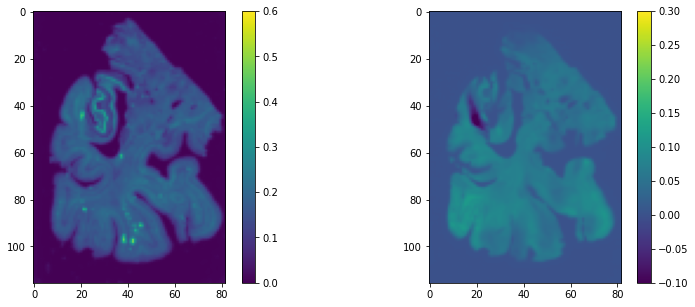

In [57]:
A = R.compute_tform(theta, dx, dy)
q = R.apply_tform_to_moving(A)
fig, (ax1, ax2) = plt.subplots(figsize=(13, 5), ncols=2);
fig.colorbar(ax1.imshow(R.I_fix.T.squeeze(), vmin=0.0, vmax=0.6), ax=ax1);
fig.colorbar(ax2.imshow(torch.sum(q * R.M_fix.T, axis=0).squeeze().detach(), vmin=-0.1, vmax=0.3), ax=ax2);

In [39]:
OL = pwreg.OverlapLoss(q.shape, R.M_fix.T)
A_inv = torch.inverse(R.compute_tform(theta, dx, dy))
M_inv = OL.overlap_image(A_inv)

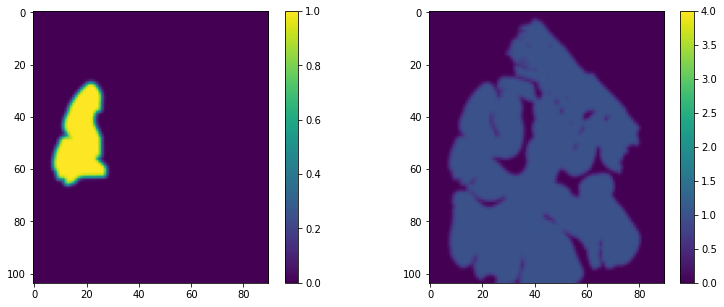

In [58]:
fig, (ax1, ax2) = plt.subplots(figsize=(13, 5), ncols=2)
fig.colorbar(ax1.imshow(M_inv[1,0,:,:].detach()), ax=ax1)
fig.colorbar(ax2.imshow(torch.sum(M_inv, axis=0).squeeze().detach(), vmin=0, vmax=4), ax=ax2)

In [31]:
OL(A_inv)

tensor(0.0477, grad_fn=<DivBackward0>)

In [59]:
A

tensor([[[ 9.0579e-01,  1.6762e-02, -7.5069e-03],
         [-1.0224e-02,  1.1154e+00,  1.6586e-01],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.0587e-01, -4.2471e-03, -7.8978e-02],
         [ 2.5906e-03,  1.1155e+00,  2.5635e-02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.0040e-01,  1.4124e-01, -3.9148e-04],
         [-8.6153e-02,  1.1088e+00, -1.2092e-02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.0235e-01,  1.1334e-01, -5.0859e-02],
         [-6.9136e-02,  1.1112e+00, -3.0919e-03],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.0493e-01,  5.8556e-02, -1.1907e-01],
         [-3.5717e-02,  1.1144e+00,  1.3355e-02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.0580e-01,  1.6117e-02, -1.0453e-01],
         [-9.8308e-03,  1.1154e+00,  1.4001e-02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.0578e-01, -1.8723e-02, -1.7573e-01],
         [ 1.1420e-02,  1.1154e+00, -1

In [60]:
ncc

tensor([0.7422, 0.7054, 0.7851, 0.8014, 1.0994, 0.9737, 0.9205, 1.0673],
       grad_fn=<DivBackward0>)

In [63]:
ncc_maps=R.ncc.ncc_maps(R.I_fix.T, R.apply_tform_to_moving(R.compute_tform(theta, dx, dy)), R.M_fix.T)

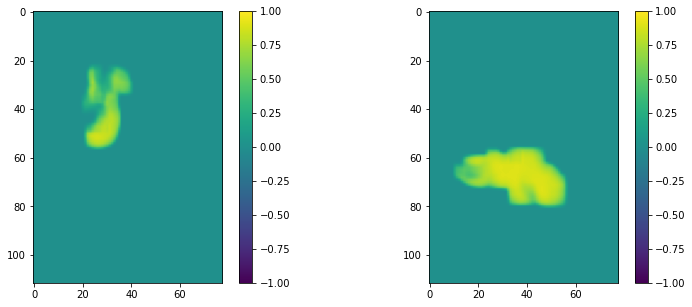

In [65]:
fig, (ax1, ax2) = plt.subplots(figsize=(13, 5), ncols=2)
fig.colorbar(ax1.imshow(ncc_maps[0,:,:].detach(), vmin=-1, vmax=1), ax=ax1)
fig.colorbar(ax2.imshow(ncc_maps[4,:,:].detach(), vmin=-1, vmax=1), ax=ax2)